##### imports

In [1]:
import csv
import numpy as np
import pandas as pd
import scipy as sp

import time as tm
import timeit

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import mpld3 #interactive plot -> mpld3.enable_notebook()
from mpl_toolkits.mplot3d import Axes3D
# create custom color maps
from matplotlib import cm
plt.style.use('default')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import os
from os import listdir
import glob
from tqdm import tqdm

import sklearn
import sklearn.mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import phate

In [2]:
from Connectome_Template_functions import subject_data, plot_BOLD_ts, calc_FC, calc_FCs_ut, \
calc_FCs_stream_variants, calc_FCD, calc_edge_ts, calc_RSS, run_KMeans, PCA_sklearn, \
calc_FCD_states, create_2D_brain_plot

In [3]:
parameters = {'axes.labelsize': 22,
              'axes.titlesize': 22,
              'legend.fontsize': 22,
              'xtick.labelsize': 22,
             'ytick.labelsize': 22}
plt.rcParams.update(parameters)
plt.rcParams["figure.figsize"] = (10,6)

In [4]:
# sampling frequency of the BOLD signal
TR = 0.72

In [5]:
preprocessings = ['dicer', 'gsr', 'orig']

In [6]:
data_list, weights = subject_data(os.path.split(os.getcwd())[0], '/data/ins-amu SipEtAl22_ParamInferenceWithUnknownDynamics main study-data/101309/',
                                             'npy', '/region_names.txt', '/weights.txt', use_time=False, sampling_rate=TR)

In [7]:
N_samples, N_regions = data_list[0].shape

In [8]:
# BOLD_plot = plot_BOLD_ts(subj09_data)

### data analysis pipeline

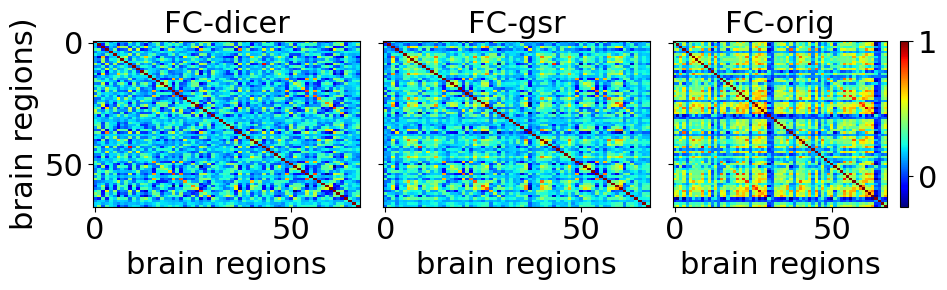

In [9]:
FC_list = calc_FC(data_list, preprocessings, plot=True)

In [10]:
FCs_ut_list, windowed_time = calc_FCs_ut(data_list, 30, use_time=False, sampling_rate=TR)

In [11]:
# samples x upper triagonal elements
FCs_ut_list[0].shape

(1171, 2278)

In [12]:
FC_stream, _ = calc_FCs_stream_variants(data_list, FCs_ut_list)

In [13]:
FC_stream[0].shape

(1171,)

In [14]:
FCDs_list = calc_FCD(data_list, FCs_ut_list)

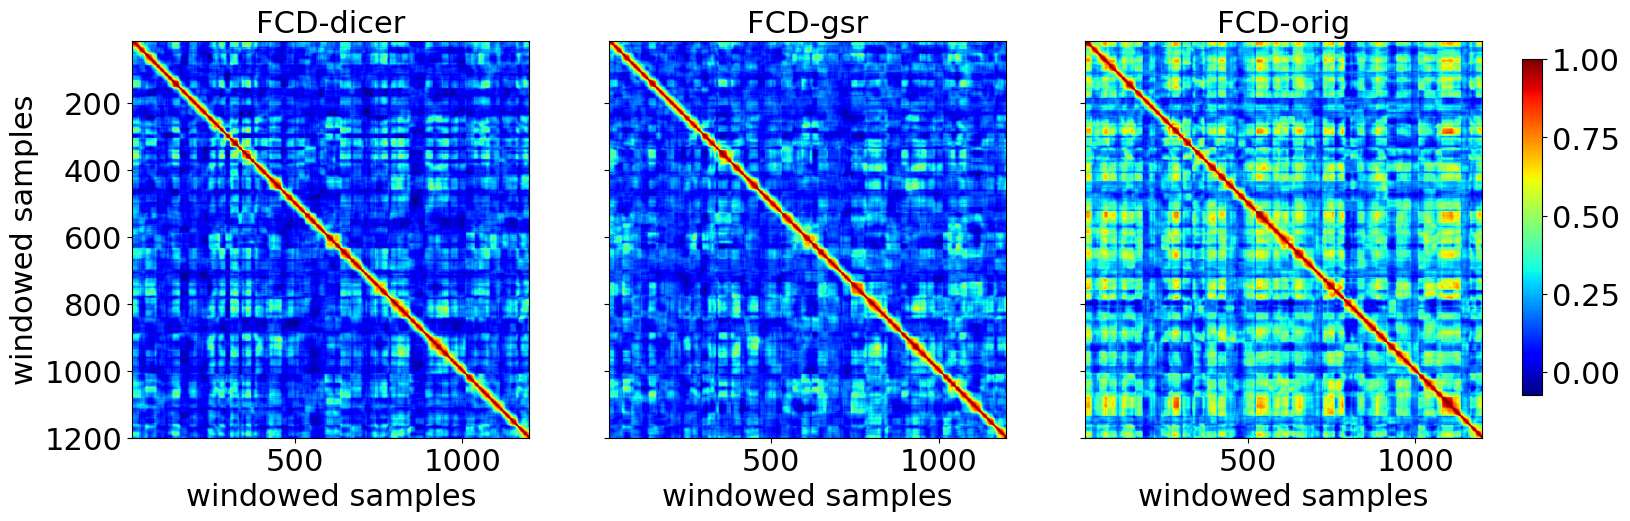

In [15]:
fig, ax = plt.subplots(1,3, sharey=True,figsize = (20,24))
use_time = False
if use_time == True:
    xlabel = 'windowed time'
else:
    xlabel = 'windowed samples'

for i in range(len(data_list)):

    im3 = ax[i].imshow(FCDs_list[i], cmap='jet', aspect='equal', interpolation='none',
                      extent=[windowed_time[0], windowed_time[-1], windowed_time[-1], windowed_time[0]])
    ax[i].set_xlabel(xlabel)
    ax[i].set_title('FCD-'+preprocessings[i])
ax[0].set_ylabel(xlabel)#, fontsize=11)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.43, 0.01, 0.14])
plt.colorbar(im3, cax=cbar_ax, shrink = 0.15);

# plt.tight_layout();

In [16]:
Enm_list, Enm_ut_list = calc_edge_ts(data_list)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


In [17]:
RSS_list, RSS_95th_percentile_list, RSS_colors_strings = calc_RSS(data_list, Enm_list)

In [18]:
n_Enm_clusters = [2,3,4]
km_colors = ['green', 'cyan', 'brown', 'red', 'yellow', 'k']

In [19]:
km_Enm_labels_list, silh_Enm_avg_list, best_idx_Enm__list = run_KMeans(Enm_ut_list, n_Enm_clusters)

100%|█████████████████████████████████████████████| 3/3 [00:10<00:00,  3.66s/it]


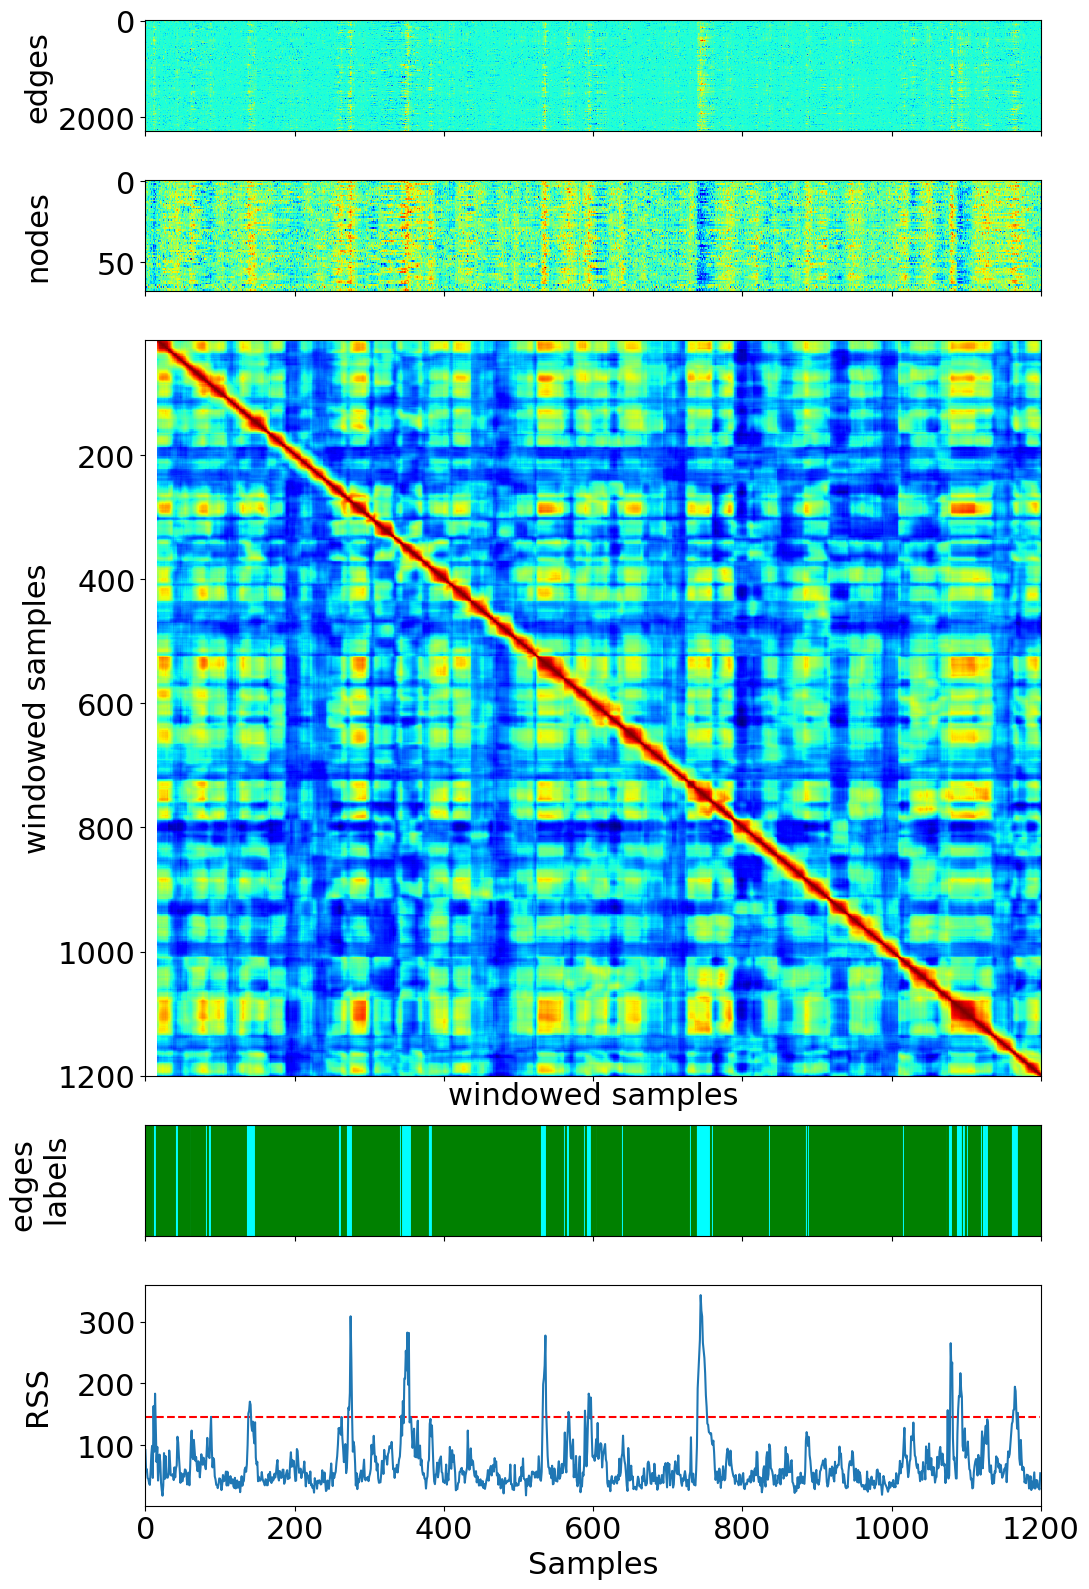

In [20]:
fig, axes = plt.subplots(5, 1, sharex=True,figsize = (11,16),
                         gridspec_kw={'height_ratios': [1.5, 1.5, 10, 1.5, 3]})
axes[0].imshow(Enm_ut_list[2].T, cmap='jet', aspect='auto', interpolation='none')
axes[0].set_ylabel('edges')

axes[1].imshow(data_list[2].T, cmap='jet', aspect='auto', interpolation='none')
axes[1].set_ylabel('nodes')#, fontsize=11)

axes[2].imshow(FCDs_list[2], cmap='jet', aspect='auto', interpolation='none', 
              extent = [windowed_time[0], windowed_time[-1], windowed_time[-1], windowed_time[0]])
axes[2].set_ylabel('windowed samples')#, fontsize=11)
axes[2].set_xlabel('windowed samples')#, fontsize=11)

for i, k in enumerate(km_Enm_labels_list[2][best_idx_Enm__list[2], :]):
    axes[3].vlines(np.arange(N_samples)[i], 0, 50, colors = km_colors[int(k)])
axes[3].set_ylim(0,50);
axes[3].set_xlim(0,1200);
axes[3].tick_params(left = False, labelleft=False)
axes[3].set_ylabel('edges \n labels \n \n')

axes[4].hlines(RSS_95th_percentile_list[2], np.arange(N_samples)[0], np.arange(N_samples)[-1], linestyles='--', color = 'red')
axes[4].plot(np.arange(N_samples), RSS_list[2])
axes[4].set_ylabel('RSS')
axes[4].set_xlabel('Samples')

fig.align_ylabels([axes[0],axes[1],axes[2],axes[-1]])
plt.tight_layout()
plt.show()

#### PCA on BOLD data

In [21]:
var_expl, PCs, PCA_data = [], [],[]
for i in range(len(data_list)):
    PCA_results = PCA_sklearn(data_list[i], N_regions)
    var_expl.append(PCA_results[0])
    PCs.append(PCA_results[1]) 
    PCA_data.append(PCA_results[2])

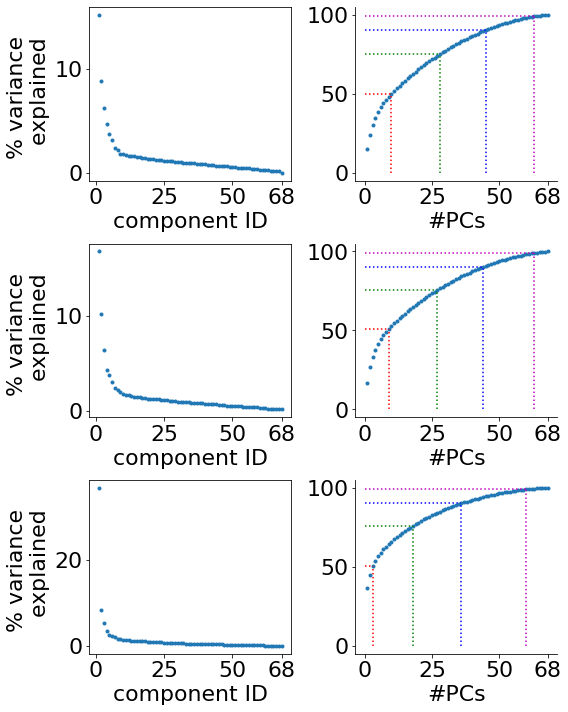

In [22]:
%matplotlib inline

fig, ax = plt.subplots(len(data_list), 2, figsize = (8,10))
#                          gridspec_kw={'height_ratios': [3, 0.75, 0.75]})
for i in range(len(data_list)):
    cvar = np.zeros(var_expl[i].shape[0])
    for n in range(var_expl[i].shape[0]):
        if n == 0:
            cvar[n] = var_expl[i][n]
        else:
            cvar[n] = var_expl[i][n] + cvar[n-1]
    n_PCs = np.arange(var_expl[i].shape[0])+1
#     plt.figure(figsize=(14,7))
#     plt.subplot(121)
#     print(n_PCs, var_expl_sklearn[i]*100)
    ax[i,0].plot(n_PCs, var_expl[i]*100, ".")
    ax[i,0].set_xlabel('component ID')
    ax[i,0].set_ylabel('% variance \n explained')
#     ax[i,0].xscale("log")

    def cum_plot(cvar, selective_v):
        a = ((np.array(np.where(cvar > selective_v))).T)+1
        return a[0]

    selective_v = [0.50, 0.75, 0.90, 0.99]
    colors = ['r', 'g', 'b', 'm']

#     plt.subplot(122)
    ax[i,1].plot(n_PCs, cvar*100, ".")
    for n in range(len(selective_v)):
        ax[i,1].vlines(cum_plot(cvar, selective_v[n]),0,cvar[(cum_plot(cvar, selective_v[n]))-1]*100, linestyle="dotted", color = colors[n],
                       label = str(int(cum_plot(cvar, selective_v[n])))+' Pcs for >'+str(int(selective_v[n]*100))+' %')
        ax[i,1].hlines(cvar[(cum_plot(cvar, selective_v[n]))-1]*100,0,cum_plot(cvar, selective_v[n]), linestyle='dotted', color = colors[n])
    sns.despine(right=True, ax=ax[i,1])
    ax[i,1].set_xticks([0,25,50,N_regions])
    ax[i,0].set_xticks([0,25,50,N_regions])
    ax[i,1].set_xlabel('#PCs')
    # ax[i,1].set_ylabel('% total \n variance \n explained')
plt.tight_layout()
plt.show()

In [23]:
# check if the PCA data == projection of data to the PCs eigenspace
# for i in range(3):
#     print(PCA_data[0][:,i] == PCs[0][:,i][:,None].T @ data_list[0].T)

##### find PC loadings

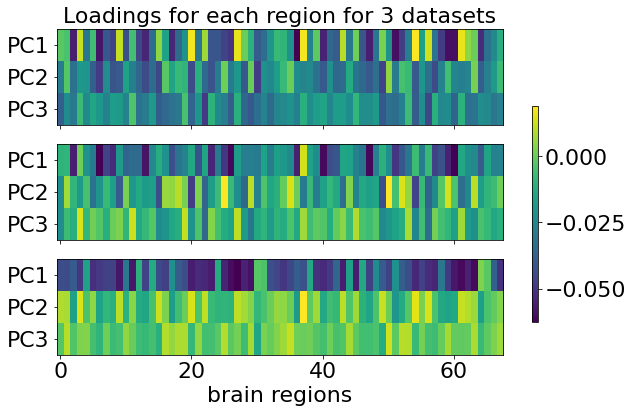

In [24]:
# loadings plot 
fig, ax = plt.subplots(3, 1, figsize = (8,6), sharex = True)
for i in range(len(data_list)):
    im_i = ax[i].imshow(np.multiply(PCs[i][:,:3],var_expl[i][:3]).T, aspect = 'auto') 
    ax[i].set_yticks(ticks = [0,1,2], labels = ["PC1","PC2","PC3"])
ax[0].set_title('Loadings for each region for {} datasets'.format(len(data_list)));
ax[2].set_xlabel('brain regions')
cbar_ax = fig.add_axes([0.95, 0.2, 0.01, 0.5])
plt.colorbar(im_i, cbar_ax)
plt.show()

In [65]:
# for orig dataset
PCs_loadings2 = np.multiply(PCs[2][:,:3],var_expl[2][:3]).T

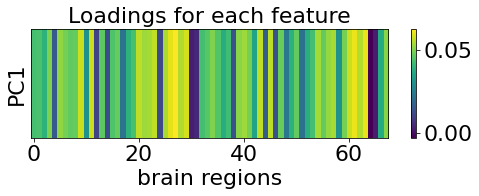

In [66]:
fig, ax1 = plt.subplots(1, 1, figsize = (8,2), sharex = True)

im_PC1 = ax1.imshow(-PCs_loadings2[0,:][None,:], aspect = 'auto') 
ax1.tick_params(left = False, labelleft=False)
ax1.set_title('Loadings for each feature');
ax1.set_xlabel('brain regions')
ax1.set_ylabel('PC1')

plt.colorbar(im_PC1, ax = ax1)
plt.show()

##### Combine loadings and weights for a 2D brain plot

In [42]:
colours_loadings_PC1 = im_PC1.cmap(im_PC1.norm(-PCs_loadings2[0,:][None,:]))

In [43]:
centersDK = pd.read_csv('centresDK.csv')
centersDK = centersDK.T

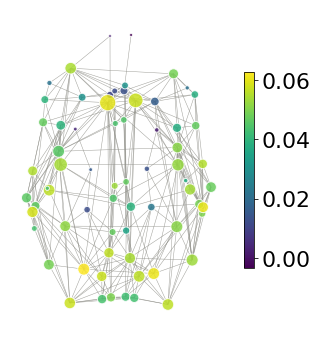

In [45]:
# weights determine the size, loadings determine the color
create_2D_brain_plot(weights, centersDK.values, threshold=100,
                    color_nodes=colours_loadings_PC1.squeeze(), mappable=im_PC1,
                    size_nodes=weights.sum(axis = 0)/100,
                   alpha_node=0.85)

##### PCA results combined with classes on edge series and coactivation events

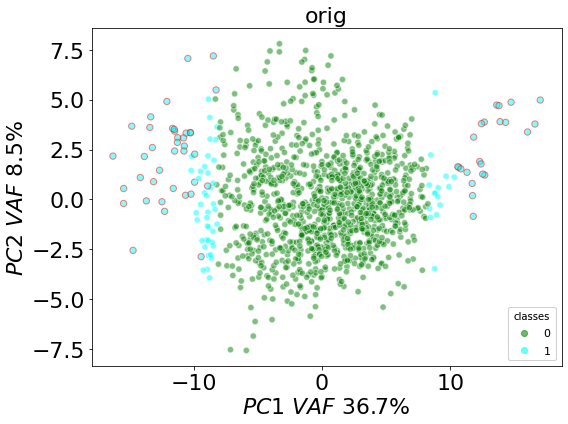

In [25]:
%matplotlib inline

fig, ax = plt.subplots(1,1, sharex='col',figsize = (8,6))

i = 2 #2nd dataset
j=0   #1st kmeans clustering
data2_PCA = ax.scatter(PCA_data[i][:,0],
                              PCA_data[i][:,1],
                              c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=40,
                              cmap = ListedColormap(['green', 'cyan']), 
                              alpha = 0.5)
if j == 0:

    ax.set_title(preprocessings[i])
    ax.set_ylabel(r'$PC2 \ VAF \ {}\%$'.format((100*var_expl[2][1]).round(1)))
if i == len(data_list)-1:
    ax.set_xlabel(r'$PC1 \ VAF \ {}\%$'.format((100*var_expl[2][0]).round(1)))

# produce a legend with the unique colors from the scatter
if i == len(data_list)-1:
    legend1 = ax.legend(*data2_PCA.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 11})
    ax.add_artist(legend1)

plt.tight_layout()
plt.show()

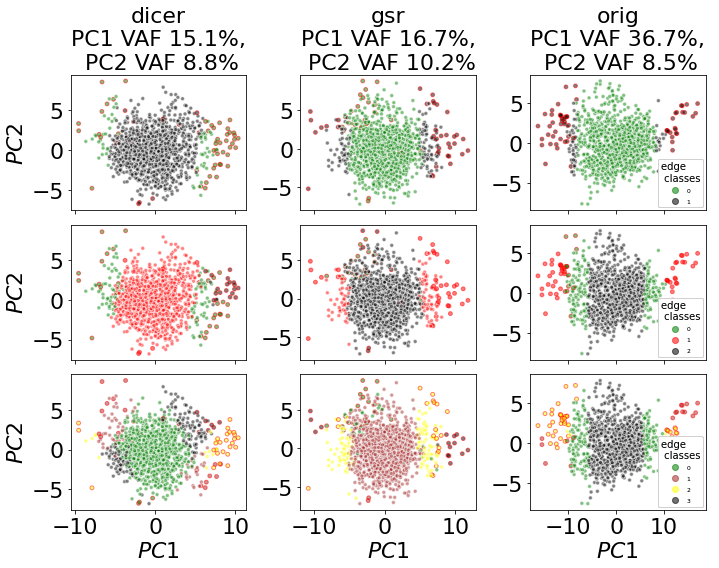

In [26]:
%matplotlib inline

fig, ax = plt.subplots(3,3, sharex='col',figsize = (10,8))

for i in range(len(data_list)):
    for j in range(len(n_Enm_clusters)):
        data_PCA = ax[j,i].scatter(PCA_data[i][:,0],
                                      PCA_data[i][:,1],
                                      c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=15,
                                      cmap = ListedColormap(km_colors), 
                                      alpha = 0.5)
        if j == 0:
    
            ax[j,i].set_title(preprocessings[i] + '\n PC1 VAF {}%, \n PC2 VAF {}%'.format((100*var_expl[i][0]).round(1), (100*var_expl[i][1]).round(1)))
            ax[i,j].set_ylabel(r'$PC2$')
        if i == len(data_list)-1:
            ax[i,j].set_xlabel(r'$PC1$')
            
# produce a legend with the unique colors from the scatter
        if i == len(data_list)-1:
            legend1 = ax[j,i].legend(*data_PCA.legend_elements(),
                                    loc="lower right", title="edge \n classes", prop={'size': 6})
            ax[j,i].add_artist(legend1)

plt.tight_layout()
plt.show()

#### Find FCD states

In [27]:
n_FCD_clusters = [3, 4, 5, 6]
km_FCsut_labels_list, silh_FCsut_avg_list, best_idx_FCsut_list = run_KMeans(FCs_ut_list, n_FCD_clusters)

100%|█████████████████████████████████████████████| 3/3 [00:19<00:00,  6.55s/it]


In [28]:
km_df_list, km_windowed_time_df_list, grouped_km_df_list = \
calc_FCD_states(data_list, windowed_time, 10,
                km_FCsut_labels_list, best_idx_FCsut_list, km_colors)

 33%|███████████████                              | 1/3 [00:00<00:00,  9.51it/s]

check: 23 >= 23
check: 22 >= 22
check: 20 >= 19


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 12.70it/s]


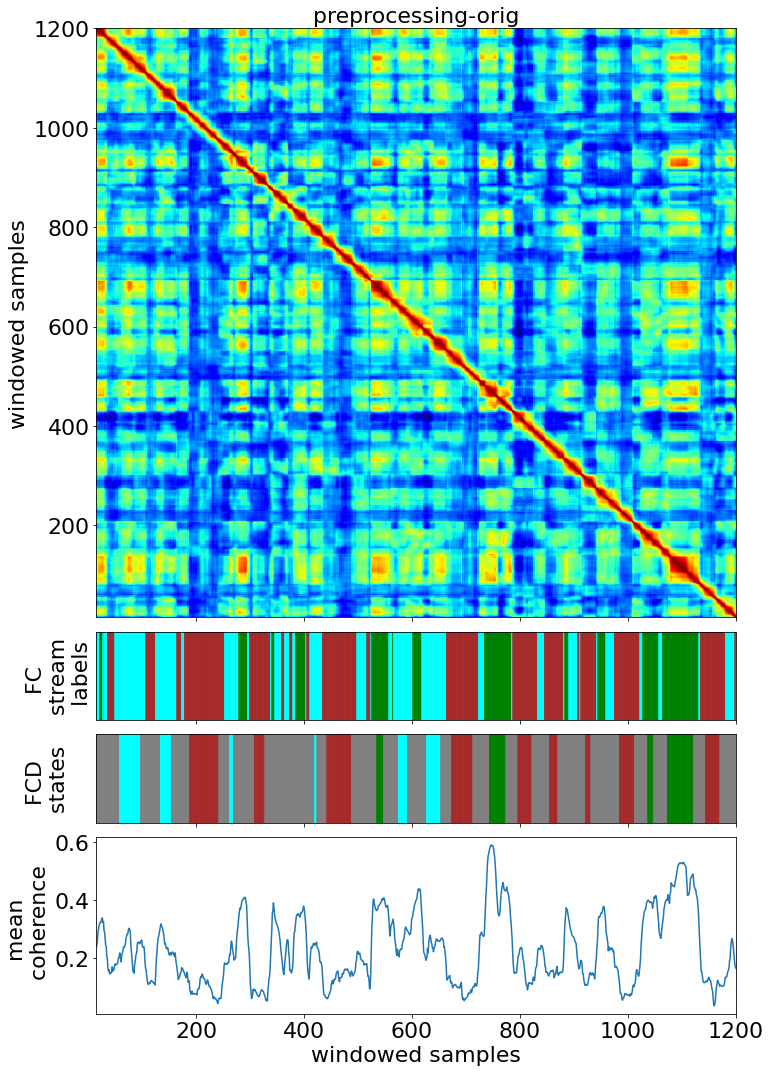

In [29]:
%matplotlib inline

fig, ax = plt.subplots(4, 1, sharex=True,figsize = (11,15),
                      gridspec_kw={'height_ratios': [10, 1.5, 1.5, 3]})#, 0.75, 0.75]})
use_time = False
if use_time == True:
    xlabel = r'$time \ [sec]$'
else:
    xlabel = 'samples'

# FCD plot
imFCD = ax[0].imshow(FCDs_list[2], cmap='jet', aspect='auto', interpolation='none',
                    extent = [windowed_time[0], windowed_time[-1],windowed_time[0], windowed_time[-1]])
ax[0].set_title('preprocessing-'+preprocessings[2])
ax[0].set_ylabel(r'windowed '+xlabel)#, fontsize=11)

# k-means clustering plot
# for j in range(len(subject_data)):
for i, k in enumerate(km_FCsut_labels_list[2][best_idx_FCsut_list[2], :]):
    ax[1].vlines(windowed_time[i], 0, 50, colors = km_colors[int(k)])
ax[1].set_ylim(0,50);
ax[1].tick_params(left = False, labelleft=False)
ax[1].set_ylabel('FC \n stream \n labels')

for i, k in enumerate(km_windowed_time_df_list[2]["kmeans colors"]):
    ax[2].vlines(windowed_time[i], 0, 50, colors = k)
# ax[1].set_xlim(0,N_FCD_upper)
ax[2].set_ylim(0,50);
ax[2].tick_params(left = False, labelleft=False)
ax[2].set_ylabel('FCD \n states \n')
# ax[2].set_title('k_means {}-'.format(element_of_n_clusters + n_FCstream_clusters[0]) + preprocessings[2])

# fc-stream plot
ax[3].plot(windowed_time, FC_stream[2])
ax[3].set_ylabel('mean \n coherence')
# ax[2].set_title('FC stream-'+preprocessings[2])
ax[3].set_xlabel('windowed ' + xlabel)#, fontsize=15)

fig.align_ylabels([ax[1], ax[2]])
plt.tight_layout()
plt.show()

##### FCD states on PCA results

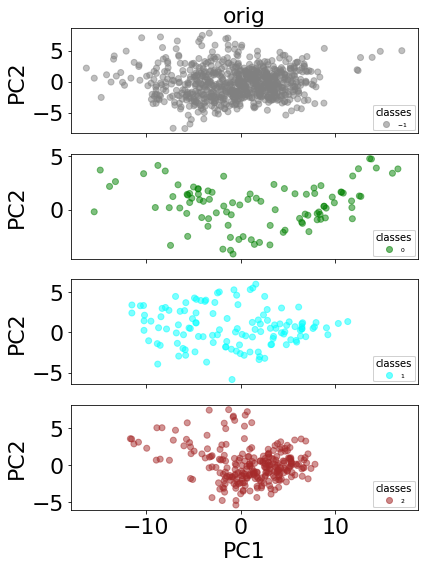

In [51]:
%matplotlib inline
t = np.arange(N_samples)
up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(grouped_km_df_list[2].index.shape[0], 1, sharex=True, figsize = (6,8))
colors_classes = []
for i,j in zip(grouped_km_df_list[2].index, 
               range(grouped_km_df_list[2].index.shape[0])):
    colors_classes.append(grouped_km_df_list[2][i[0]].index[0])
    orig_PCA = axes[j].scatter(PCA_data[2][:,0][grouped_km_df_list[2][i[0]].values[0]],
                      PCA_data[2][:,1][grouped_km_df_list[2][i[0]].values[0]],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[grouped_km_df_list[2][i[0]].values[0]],# edgecolors = RSS_colors_strings[:up_to_sample],
                      alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[2][i[0]].index[0]))# c=km_labels[2][0], s=15, 
    legend1 = axes[j].legend(*orig_PCA.legend_elements(),
               loc="lower right", title="classes", prop={'size': 6})
    axes[j].add_artist(legend1)
    axes[j].set_ylabel('PC2')
axes[0].set_title('orig')
axes[-1].set_xlabel('PC1')


fig.align_ylabels(axes)
plt.tight_layout()
plt.show()

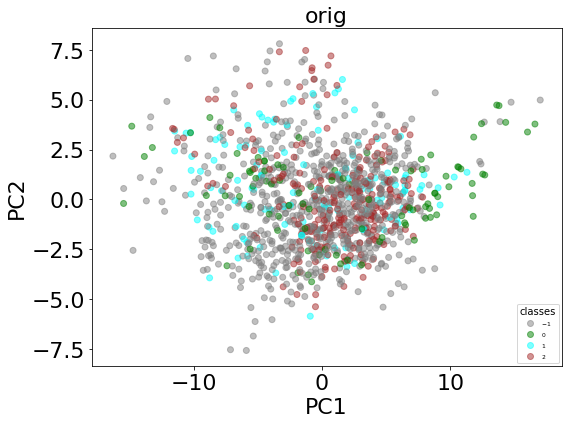

In [53]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
plt.figure(figsize = (8,6))

orig_PCA_FCD = plt.scatter(PCA_data[2][:,0][:up_to_sample],
                      PCA_data[2][:,1][:up_to_sample],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[:up_to_sample],# edgecolors = RSS_colors_strings[:up_to_sample],
                      cmap = ListedColormap(colors_classes),
                      alpha = 0.5)
plt.legend(*orig_PCA_FCD.legend_elements(),
           loc="lower right", title="classes", prop={'size': 6})
plt.title('orig')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

#### PHATE

In [72]:
# fitting
phate_operator2d_eucl = phate.PHATE(n_components=2 ,knn_dist='euclidean', mds_dist='euclidean', n_jobs=-1)
data_2Dphate_eucl = []
phate_fit2d_eucl = []
for i in range(len(data_list)):
    print(i+1,' iteration'.format(i+1))
    phate_fit2d_eucl.append(phate_operator2d_eucl.fit(data_list[i]))
    print('\n Transformation now starts \n')
    data_2Dphate_eucl.append(phate_fit2d_eucl[i].transform(data_list[i]))

1  iteration
Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.12 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.17 seconds.

 Transformation now starts 

Calculating optimal t...
  Automatically selected t = 21
Calculated optimal t in 1.21 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.50 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.75 seconds.
2  iteration
Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.13 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.17 seconds.

 Transformation now starts 

Calculating optimal t...
  Automatically selected t = 24
Calculated optimal t in 1.41 s

In [73]:
# normalized kernel matrix
phate_fit2d_eucl[2].diff_op.shape

(1200, 1200)

In [74]:
# potential distance matrix
phate_fit2d_eucl[2].diff_potential.shape

(1200, 1200)

In [75]:
# phate loadings for orig dataset
# NOT RIGOROUS!, but checks correspondence with PCA loadings
phate_loadings_orig = data_2Dphate_eucl[2].T @ data_list[2]

In [76]:
PCs_loadings2.shape

(3, 68)

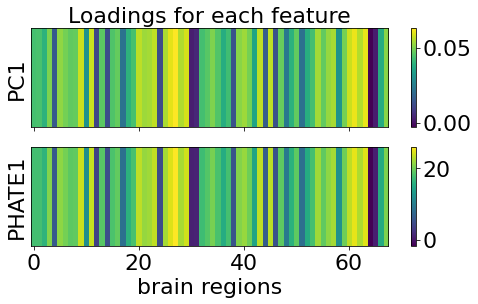

In [77]:
fig, ax = plt.subplots(2, 1, figsize = (8,4), sharex = True)
ax1 , ax2 = ax.ravel()

im_PC1 = ax1.imshow(-PCs_loadings2[0,:][None,:], aspect = 'auto') 
im_phate = ax2.imshow(phate_loadings_orig.values[0,:][None,:], aspect = 'auto')
ax1.tick_params(left = False, labelleft=False)
ax2.tick_params(left = False, labelleft=False)
ax1.set_title('Loadings for each feature');
ax2.set_xlabel('brain regions')

ax1.set_ylabel('PC1')
ax2.set_ylabel('PHATE1')
plt.colorbar(im_PC1, ax = ax1)
plt.colorbar(im_phate, ax = ax2)
plt.show()

##### **PHATE with edge classes**

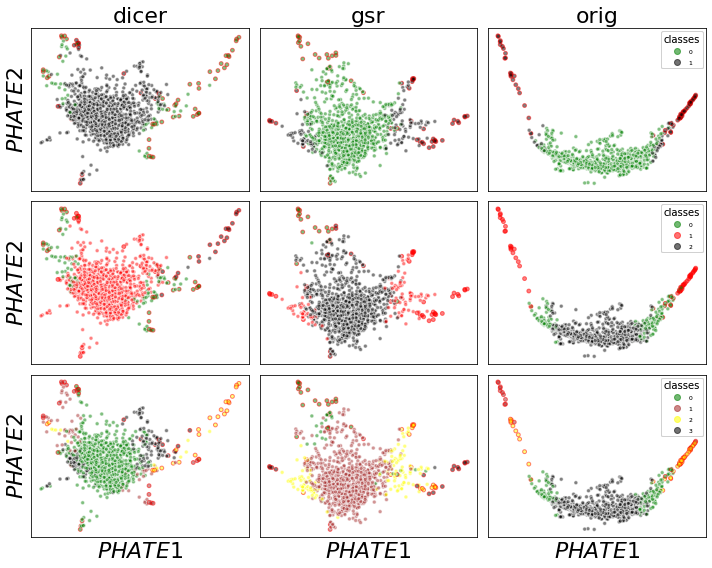

In [79]:
%matplotlib inline

fig, ax = plt.subplots(3,3, sharex='col',figsize = (10,8))

for i in range(len(data_list)):
    for j in range(len(n_Enm_clusters)):
        data_PHATE = ax[j,i].scatter(data_2Dphate_eucl[i][:,0],
                                      data_2Dphate_eucl[i][:,1],
                                      c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=15, 
                                      cmap=ListedColormap(km_colors),alpha = 0.5)
        ax[j,i].tick_params(labelleft=False, left = False, labelbottom=False, bottom=False)
        if j == 0:
    
            ax[j,i].set_title(preprocessings[i])
            ax[i,j].set_ylabel(r'$PHATE2$')
        if i == len(data_list)-1:
            ax[i,j].set_xlabel(r'$PHATE1$')
            
# produce a legend with the unique colors from the scatter
        if i == len(data_list)-1:
            legend1 = ax[j,i].legend(*data_PHATE.legend_elements(),
                                    loc="upper right", title="classes", prop={'size': 6})
            ax[j,i].add_artist(legend1)

plt.tight_layout()
plt.show()

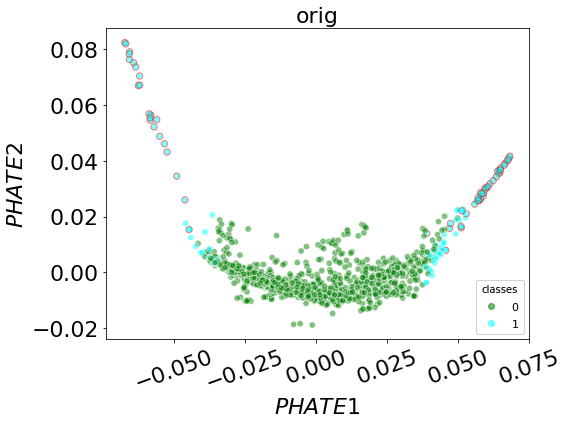

In [88]:
%matplotlib inline

fig, ax = plt.subplots(1,1, sharex='col',figsize = (8,6))

i = 2 # orig dataset
j=0 # 1st kmeans cluster
orig_PHATE = ax.scatter(data_2Dphate_eucl[i][:,0],
                          data_2Dphate_eucl[i][:,1],
                          c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=40,
                          cmap = ListedColormap(['green', 'cyan']), 
                          alpha = 0.5)
if j == 0:

    ax.set_title(preprocessings[i])
    ax.set_ylabel(r'$PHATE2$')
if i == len(data_list)-1:
    ax.set_xlabel(r'$PHATE1$')

# produce a legend with the unique colors from the scatter
if i == len(data_list)-1:
    legend1 = ax.legend(*orig_PHATE.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 11})
    ax.add_artist(legend1)
ax.tick_params(axis='x', labelrotation= 20)
plt.tight_layout()
plt.show()

##### **PHATE with FCD classes**

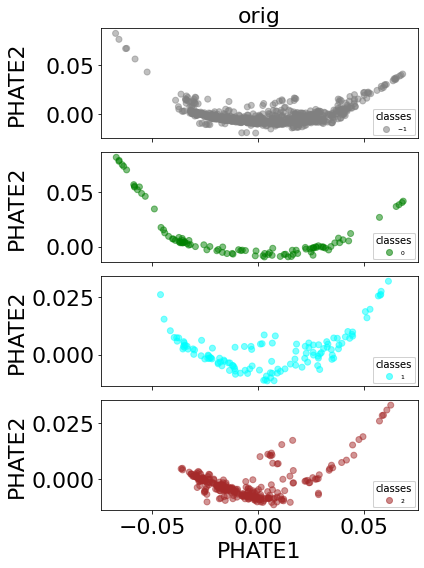

In [83]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(grouped_km_df_list[2].index.shape[0], 1, sharex=True, figsize = (6,8))
for i,j in zip(grouped_km_df_list[2].index, 
               range(grouped_km_df_list[2].index.shape[0])):
    orig_PHATE_FCD_sep = axes[j].scatter(data_2Dphate_eucl[2][:,0][grouped_km_df_list[2][i[0]].values[0]],
                      data_2Dphate_eucl[2][:,1][grouped_km_df_list[2][i[0]].values[0]],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[grouped_km_df_list[2][i[0]].values[0]],
                      alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[2][i[0]].index[0]))
    legend1 = axes[j].legend(*orig_PHATE_FCD_sep.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 6})
    axes[j].add_artist(legend1)
    axes[j].set_ylabel('PHATE2')
axes[0].set_title('orig')
axes[-1].set_xlabel('PHATE1')
fig.align_ylabels(axes)


plt.tight_layout()
plt.show()

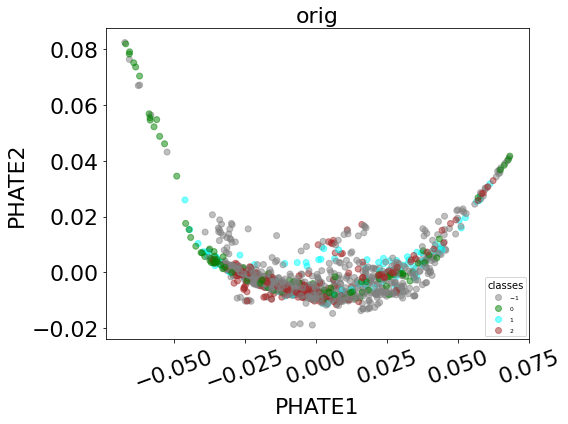

In [90]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
plt.figure(figsize = (8,6))
orig_PHATE_FCD_all = plt.scatter(data_2Dphate_eucl[2][:,0][:up_to_sample],
                      data_2Dphate_eucl[2][:,1][:up_to_sample],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[:up_to_sample],# edgecolors = RSS_colors_strings[:up_to_sample],
                      cmap = ListedColormap(colors_classes),
                      alpha = 0.5)
plt.legend(*orig_PHATE_FCD_all.legend_elements(),
           loc="lower right", title="classes", prop={'size': 6})
plt.title('orig')
plt.xlabel('PHATE1')
plt.ylabel('PHATE2')

plt.tick_params(axis='x', labelrotation= 20)
plt.tight_layout()
plt.show()